<a href="https://colab.research.google.com/github/mingmingbupt/tensorflow/blob/master/tf_keras_classification_model_callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#%tensorflow_version 2.x
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


1.15.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.0
numpy 1.18.2
pandas 0.25.3
sklearn 0.22.2.post1
tensorflow 1.15.0
tensorflow.python.keras.api._v1.keras 2.2.4-tf


In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [0]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [5]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
# Tensorboard, earlystopping, ModelCheckpoint
#用于tensorboard
logdir = 'tb_logs'
if not os.path.exists(logdir):
    os.mkdir(logdir)

#用于存储checkpoint
output_model_file = os.path.join(logdir,"fashion_mnist_model.h5")


#callback是在训练过程中做一些监听，所以是在fit函数里对callback进行添加
#添加方式 就是我们定义一个callback的数组，在fit函数里把这个数组作为参数传进来
#我们在数组里就定义了我们需要的callback,这里用了三个callback, tensorboard, checkpoint, earlystoping
#对于tensorboard 我需要的是一个文件夹
#对于checkpint 我需要的是一个文件名

callbacks = [
    keras.callbacks.TensorBoard(logdir),  # tensorboard的callback
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True), # model checkpoint 的callback，保存最好的模型，默认会保存最近的模型
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
    # early stopping 比较重要的是三个参数
    # 第一个参数 monitor: 我要关注的是哪一个指标，一般呢，我们关注的是验证集合目标函数的值
    # 第二个参数 min_dilta： 一个阈值，这次训练和上次训练的差距是不是比这个阈值低，如果高的话，就不用early stopping
    # 第三个参数 patience ： 当我前后两次目标函数值的差距比这个min_dilta要小的时候，那我连续多少次这样的情况，我就要把他提前关闭
]
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 91us/sample - loss: 0.5331 - acc: 0.8098 - val_loss: 0.4096 - val_acc: 0.8538
Epoch 2/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.3887 - acc: 0.8619 - val_loss: 0.3681 - val_acc: 0.8688
Epoch 3/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.3496 - acc: 0.8738 - val_loss: 0.3431 - val_acc: 0.8800
Epoch 4/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.3244 - acc: 0.8829 - val_loss: 0.3332 - val_acc: 0.8812
Epoch 5/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.3060 - acc: 0.8889 - val_loss: 0.3398 - val_acc: 0.8822
Epoch 6/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.2894 - acc: 0.8935 - val_loss: 0.3217 - val_acc: 0.8838
Epoch 7/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.2751 - acc: 0.8997 - val_loss: 0.3

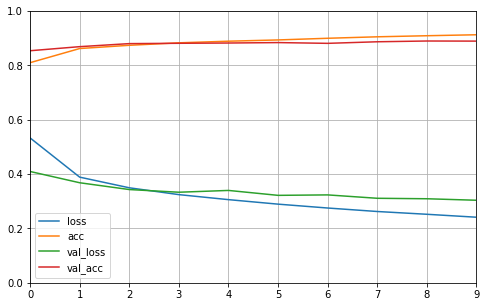

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [8]:
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 0s 40us/sample - loss: 0.3377 - acc: 0.8802


[0.3376764321565628, 0.8802]

In [9]:
!ls tb_logs

events.out.tfevents.1584862937.2638565c0db2		   plugins
events.out.tfevents.1584862937.2638565c0db2.profile-empty  train
fashion_mnist_model.h5					   validation


# 新段落

In [10]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# 添加TensorBoard的路径
import os
log_dir = 'tb_logs'
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

# 开启ngrok service，绑定port 6006(tensorboard)
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(log_dir))
get_ipython().system_raw('./ngrok http 6006 &')

# 产生网站，点击网站访问tensorboard
#!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-03-22 07:43:23--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.20.119.24, 3.227.142.238, 52.72.182.203, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.20.119.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.5’

ngrok-stable-linux- 100%[===================>]  13.13M  35.1MB/s    in 0.4s    

2020-03-22 07:43:23 (35.1 MB/s) - ‘ngrok-stable-linux-amd64.zip.5’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [11]:
# 产生网站，点击网站访问tensorboard
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys,json;print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://c36b4956.ngrok.io
